## Installing requirements

In [1]:
! export PATH='$PATH:/home/monga/.local/lib/python3.8/site-packages'

In [2]:
#import util
from psfdataset import PSFDataset, transforms
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import util_lip_data as util_lip
import custom_transforms as ctransform
from importlib import reload

In [3]:
"""
script to compute the number
of jsons created for each
word. The output is a .csv
file where for each word the
number of jsons corresponding
to train, val, and test subsets
is mentioned
"""

import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def get_rect_and_landmarks(rect, landmarks):
    # converts and returns the face rectangle and landmarks
    # in formats appropriate for the display function

    x = rect["left"]
    y = rect["top"]
    w = rect["width"]
    h = rect["height"]

    if landmarks is not None:
        temp_agg = list()
        for i in range(len(landmarks)):
            temp = list()
            temp.append(landmarks["point-" + str(i+1)]["x"])
            temp.append(landmarks["point-" + str(i+1)]["y"])
            temp_agg.append(temp)
        return (x, y, w, h), np.asarray(temp_agg)
    else:
        return (x, y, w, h), np.empty((0, 0))


def choose_the_largest_face(faces_list):
    if len(faces_list) == 1: 
        return faces_list[0]
    
    area_max = 0
    area_max_id = 0
    for i,face in enumerate(faces_list):
        (face_rect,landmarks) = face
        area = face_rect[2] * face_rect[3] # area = width * height
        if area > area_max:
            area_max = area
            area_max_id = i
    return faces_list[area_max_id]


def load_one_json_file(filename, isDebug=False):
    # load the metadata and facial landmarks

    face_rect_list = []
    landmarks_list = []
    with open(filename) as f:
        video_data_dict = json.load(f)
        # extract duration
        if video_data_dict["metaData"] is not None:
            duration = float(re.findall(r"[-+]?\d*\.\d+|\d+", video_data_dict["metaData"]["Duration"])[0])
            if isDebug:
                print("duration metadata: %.3f" % duration)

        # extract frame information aggregated for all frames
        agg_frame_data = video_data_dict["aggFrameInfo"]  # list of frame-wise visual data

        for frame_data in agg_frame_data:
            n_faces = frame_data["numFaces"]
            if isDebug:
                print("frame index: %d number of faces: %d" % (frame_data["frameIndex"], n_faces))
            
            if frame_data["facialAttributes"] is not None:# if so, the n_faces should > 0 
                faces_list = []
                for attr in frame_data["facialAttributes"]:
                    face_idx = attr["faceIndex"]
                    face_rect, landmarks = get_rect_and_landmarks(attr["faceRectangle"],
                                                                  attr["faceLandmarks"])
                    faces_list.append((face_rect, landmarks))

                face_rect_chosen, landmarks_chosen = choose_the_largest_face(faces_list)    
                face_rect_list.append(face_rect_chosen)
                landmarks_list.append(landmarks_chosen)
    
    face_rect_array = np.array(face_rect_list)
    landmarks_array = np.array(landmarks_list)
    return face_rect_array, landmarks_array








i_data = "/cache/lrw/lipread_landmarks/dlib68_2d_sparse_json/lipread_mp4"
# or i_data = "/cache/lrw/lipread_landmarks/dlib68_2d_sparse_json_defects_not_one_face/lipread_mp4"
selected_n_classes = 10 # the max is 500

cnt = 0
data = dict()

for word in os.listdir(i_data):
    if not word.startswith('.'):
        cnt += 1
        if cnt > selected_n_classes:
            break
        print(cnt,word)
        splits = dict() # 'train' 'val' and 'test' sets
        # print("analysing data for the word: '%s'" % word)
        p = os.path.join(i_data, word)
        
        for sub_dir in os.listdir(p):
            if not sub_dir.startswith('.'):
                # print(sub_dir)
                p_sub = os.path.join(p, sub_dir)
                for _, _, files in os.walk(p_sub):
                    samples_list = []
                    for filename in files:
                        if filename.endswith('.json'):
                            face_rect_array, landmarks_array = load_one_json_file(os.path.join(p_sub, filename))
                            lip_region = []
                            for j in range(len(landmarks_array)):
                                lip_region.append(landmarks_array[j][48:68])
                            samples_list.append(np.array(lip_region))
                    splits[sub_dir] = samples_list
        data[word] = splits

print('-------------------------------')
print(data.keys()) # names of all the 'selected_n_classes' classes  
print(data['THOUGHT'].keys()) # print the names of the 3 splits for the first class 'THOUGHT'
print(len(data['THOUGHT']['train'])) # print the number of train samples of the first class
print(data['THOUGHT']['train'][0].shape) # print the shape (29 frames, 68 landmarks, 2 coordinates) of the first training sample of the first class    
print('-------------------------------')                     
        


1 THOUGHT
2 INVOLVED
3 DIFFERENT
4 MAYBE
5 REPORT
6 VICTIMS
7 GETTING
8 UNION
9 MEDIA
10 VIOLENCE
-------------------------------
dict_keys(['THOUGHT', 'INVOLVED', 'DIFFERENT', 'MAYBE', 'REPORT', 'VICTIMS', 'GETTING', 'UNION', 'MEDIA', 'VIOLENCE'])
dict_keys(['val', 'test', 'train'])
1000
(29, 20, 2)
-------------------------------


# Step 0: Defining a LabelEncoder to transform text class to numberic class

In [4]:
encoder= LabelEncoder()
categories = list(data.keys())
encoder.fit(categories)

LabelEncoder()

# Step 1: Defining my custom Data loader from above 'data'. We only need to properly define iterators for train/test/validation sets

In [5]:
def generate_iterator(data, key = 'train', refLength = 29):
    iter_list = []
    x = 0
    for word, keypointsOneWord in data.items():
        

        keypointsList = keypointsOneWord[key]
        num_of_samples = len(keypointsList)
        
        ## There are some sample whose length is smaller than 29. We need to either delete it, 
        ## or extend it to 29 length for now. But this can be resolved if signature transform is introduced
        for i in range(len(keypointsList)):
             singleSample = keypointsList[i]
             if len(singleSample) < refLength:
                 singleSample = np.array(list(singleSample) + [singleSample[-1]] * (refLength - len(singleSample)))
                 keypointsList[i] = singleSample
        iter_list = iter_list + list(zip(keypointsList, np.array(list(encoder.transform([word])) * num_of_samples)))
    return iter(iter_list)

In [6]:
iter_train = generate_iterator(data, key = 'train')
iter_test = generate_iterator(data, key = 'test')
iter_val = generate_iterator(data, key = 'val')

In [7]:
iiter_test = [x for x in iter_test]
iiter_train = [x for x in iter_train]

# Step 2: Let's adapt the PSFDataset from human body movement

In [8]:
tr = transforms.Compose([
    #transforms.spatial.Crop(),
#     transforms.spatial.Normalize(),
#     transforms.SpatioTemporalPath(),
#     transforms.temporal.MultiDelayedTransformation(2),
    transforms.temporal.DyadicPathSignatures(dyadic_levels=2,
                                             signature_level=4)
])

As first steps, no transforms are introduced yet.

In [9]:
# We create new dictionaries identical to 'data' that contain the normalized landmarks without aumenting 
#the training set

    
d_normalize = {} # normalized data set
for i in data: 
    d_normalize[i] = dict((k,ctransform.normalize_based_on_first_frame(v)) for k, v in data[i].items())
    
d_rotate = {}    # rotated data set 
for i in data: 
    d_rotate[i] = dict((k,ctransform.rotate(v)) for k, v in data[i].items())
        
    
d_normalize_rotate= {} # normalized and rotated data set
for i in d_normalize:
    d_normalize_rotate[i] = dict((k,ctransform.rotate(v)) for k, v in d_normalize[i].items())

In [10]:
# We create a new dictionary identical to 'data' that contains the normalized landmarks augmenting 
#the training set

aug_data = ctransform.flip_train_augmentation(data)

d_normalize_a = {} #normalized data set
for i in data: 
    d_normalize_a[i] = dict((k,ctransform.normalize_based_on_first_frame(v)) for k, v in aug_data[i].items())
    
d_rotate_a = {}    #rotated data set 
for i in data: 
    d_rotate_a[i] = dict((k,ctransform.rotate(v)) for k, v in aug_data[i].items())
        
    
d_normalize_rotate_a= {} ## normalized and rotated data set
for i in d_normalize_a:
    d_normalize_rotate_a[i] = dict((k,ctransform.rotate(v)) for k, v in d_normalize_a[i].items())

# Step 3: Train the model

20000it [02:15, 148.01it/s]
500it [00:03, 149.31it/s]
500it [00:03, 151.05it/s]


Number of trainingset elements: 20000
Number of testset elements 500
Dimension of feature vector: 6293
Initial accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1


train_loss: nan 	test_loss: nan 	Accuracy: 0.1



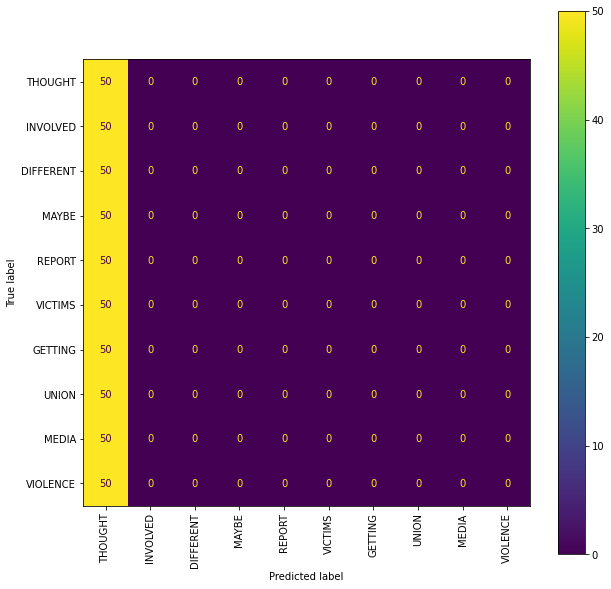

In [11]:
model, outputs = ctransform.trainModelWithSpecificDataDict(dataDict = d_normalize_rotate_a, transforms = tr, EPOCHS = 20)